##### Was running around in circles with this one for far too long, decided to look at other Kaggle submissions for better understanding. This notebook is mostly copied from one of those submissions with some of my own tweaks. 

## Importing Packages

In [60]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn import metrics
import numpy as np

## Initial Data Exploration

In [61]:
train = pd.read_csv('predict-student-performance-from-game-play/train.csv', usecols = [0], nrows = 1000000)
train.head()

,session_id
0,20090312431273200
1,20090312431273200
2,20090312431273200
3,20090312431273200
4,20090312431273200


In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   session_id  1000000 non-null  int64
dtypes: int64(1)
memory usage: 7.6 MB


In [63]:
sample = 1000000
train = pd.read_csv('predict-student-performance-from-game-play/train.csv', nrows = sample)
print('Train size of first piece:', train.shape )
train.head()

Train size of first piece: (1000000, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [64]:
labels = pd.read_csv('predict-student-performance-from-game-play/train_labels.csv')

print(labels)

labels['session'] = labels['session_id'].apply(lambda x: int(x.split('_')[0]))
                                                 
labels['question'] = labels['session_id'].apply(lambda x: int(x.split('_')[-1][1:]))
print(labels.shape)
labels.info()

                   session_id  correct
0        20090312431273200_q1        1
1        20090312433251036_q1        0
2        20090312455206810_q1        1
3        20090313091715820_q1        0
4        20090313571836404_q1        1
...                       ...      ...
424111  22100215342220508_q18        1
424112  22100215460321130_q18        1
424113  22100217104993650_q18        1
424114  22100219442786200_q18        1
424115  22100221145014656_q18        1

[424116 rows x 2 columns]
(424116, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424116 entries, 0 to 424115
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   session_id  424116 non-null  object
 1   correct     424116 non-null  int64 
 2   session     424116 non-null  int64 
 3   question    424116 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 12.9+ MB


In [65]:
labels

,session_id,correct,session,question
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


In [66]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text_fqid', 'text', 'name']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y','hover_duration']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [67]:
def feature_engineer(train):
    
    df_comps = []
########categorical###############
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        df_comps.append(tmp)
###############nums###############
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        df_comps.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        df_comps.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id', 'level_group'])[c].agg(lambda x: x.max() - x.min())
        tmp.name = tmp.name + '_range'
        df_comps.append(tmp)
    for c in NUMS: 
        tmp = train.groupby(['session_id', 'level_group'])[c].agg('median')
        tmp.name = tmp.name + '_median'
        df_comps.append(tmp)

##############EVENTS list###################""    
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8') 
    for c in EVENTS + ['elapsed_time']: 
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum') 
        tmp.name = tmp.name + '_sum' 
        df_comps.append(tmp) 
    for c in EVENTS :
        tmp = train.groupby(['session_id', 'level_group'])[c].agg(lambda x: x.mode().values[0])
        tmp.name = tmp.name + '_mode'
        df_comps.append(tmp)
   

    
    train = train.drop(EVENTS,axis=1)
    df = pd.concat(df_comps,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [68]:

    train = pd.read_csv('predict-student-performance-from-game-play/train.csv', nrows = sample)
    df = feature_engineer(train)
    df.head()

,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,text_nunique,name_nunique,elapsed_time_mean,level_mean,page_mean,...,elapsed_time_sum,navigate_click_mode,person_click_mode,cutscene_click_mode,object_click_mode,map_hover_mode,notification_click_mode,map_click_mode,observation_click_mode,checkpoint_mode
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,17,56,3,8.579356e+04,1.945455,-1.0,...,14155937,0,0,0,0,0,0,0,0,0
20090312431273200,13-22,10,49,12,35,168,3,1.040601e+06,17.402381,-1.0,...,437052322,0,0,0,0,0,0,0,0,0
20090312431273200,5-12,10,39,11,24,124,3,3.572052e+05,8.054054,-1.0,...,105732736,0,0,0,0,0,0,0,0,0
20090312433251036,0-4,11,22,6,11,49,4,9.763342e+04,1.870504,0.0,...,13571045,0,0,0,0,0,0,0,0,0
20090312433251036,13-22,11,73,16,43,183,6,2.498852e+06,17.762529,5.1,...,3241011333,0,0,0,0,0,0,0,0,0


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2656 entries, 20090312431273200 to 20100412013046310
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   level_group              2656 non-null   object 
 1   event_name_nunique       2656 non-null   int64  
 2   fqid_nunique             2656 non-null   int64  
 3   room_fqid_nunique        2656 non-null   int64  
 4   text_fqid_nunique        2656 non-null   int64  
 5   text_nunique             2656 non-null   int64  
 6   name_nunique             2656 non-null   int64  
 7   elapsed_time_mean        2656 non-null   float64
 8   level_mean               2656 non-null   float64
 9   page_mean                2656 non-null   float64
 10  room_coor_x_mean         2656 non-null   float64
 11  room_coor_y_mean         2656 non-null   float64
 12  screen_coor_x_mean       2656 non-null   float64
 13  screen_coor_y_mean       2656 non-null   float64


In [70]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 57 features
We will train with 886 users info


In [71]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}
# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25) 
    xgb_params = {
    'objective' : 'binary:logitraw',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'reg_alpha' : 0.5,
    'reg_lambda' : 0.5,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4
    }
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = labels.loc[labels['question']==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = labels.loc[labels['question']==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1(3), 2(796), 3(7), 4(8), 5(1), 6(8), 7(8), 8(1), 9(5), 10(5), 11(1), 12(7), 13(4), 14(3), 15(2), 16(8), 17(4), 18(970), 
#########################
### Fold 2
#########################
1(15), 2(969), 3(7), 4(7), 5(1), 6(9), 7(6), 8(7), 9(10), 10(2), 11(7), 12(7), 13(3), 14(8), 15(4), 16(9), 17(6), 18(7), 
#########################
### Fold 3
#########################
1(6), 2(864), 3(7), 4(6), 5(1), 6(8), 7(8), 8(1), 9(4), 10(2), 11(3), 12(7), 13(3), 14(6), 15(2), 16(8), 17(7), 18(7), 
#########################
### Fold 4
#########################
1(6), 2(879), 3(6), 4(8), 5(2), 6(5), 7(9), 8(5), 9(10), 10(4), 11(9), 12(7), 13(3), 14(6), 15(7), 16(6), 17(6), 18(6), 
#########################
### Fold 5
#########################
1(6), 2(881), 3(7), 4(7), 5(1), 6(7), 7(7), 8(2), 9(10), 10(4), 11(4), 12(8), 13(4), 14(6), 15(2), 16(12), 17(8), 18(7), 


In [72]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = labels.loc[labels['question'] == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [73]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = metrics.f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

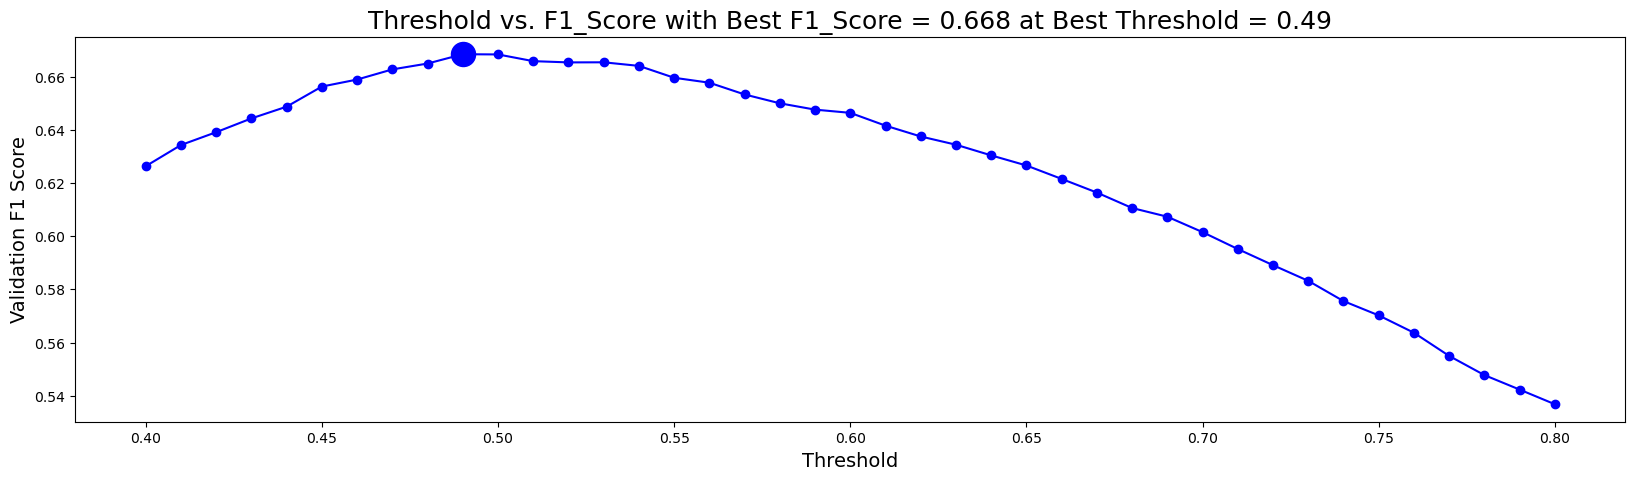

In [74]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [75]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = metrics.f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = metrics.f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5784505007770087
Q1: F1 = 0.49544419134396356
Q2: F1 = 0.4836829836829837
Q3: F1 = 0.6197917021436016
Q4: F1 = 0.5664831804281345
Q5: F1 = 0.6357564785898204
Q6: F1 = 0.5914806337017073
Q7: F1 = 0.5416817703932559
Q8: F1 = 0.5701643348259344
Q9: F1 = 0.6046313899450781
Q10: F1 = 0.579342063557823
Q11: F1 = 0.5055004773444959
Q12: F1 = 0.47071448062915006
Q13: F1 = 0.5748872756257473
Q14: F1 = 0.5466573465678737
Q15: F1 = 0.5214068501920615
Q16: F1 = 0.5784329920778464
Q17: F1 = 0.48667439165701043
==> Overall F1 = 0.6683742899296132
